In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3

database_file = 'data/database.db'
table_name = 'Main Table'

conn = sqlite3.connect(database_file)

tables_query = "SELECT * FROM 'Main Table';"

df = pd.read_sql_query(tables_query, conn)

new_df = pd.DataFrame()

In [2]:
new_df['vehicle_model'] = df['Vehicle Model']

In [3]:
# Створення словники для мінімальних та максимальних значень
min_capacity_map = {
    'BMW i3': 22.0,
    'Hyundai Kona': 48.4,
    'Chevy Bolt': 60.0,
    'Nissan Leaf': 24.0,
    'Tesla Model 3': 54.0
}

max_capacity_map = {
    'BMW i3': 42.2,
    'Hyundai Kona': 64.0,
    'Chevy Bolt': 66.0,
    'Nissan Leaf': 62.0,
    'Tesla Model 3': 82.0
}

# Створення нових стовпців з граничними значеннями для кожного рядка
df['Min_Capacity'] = df['Vehicle Model'].map(min_capacity_map)
df['Max_Capacity'] = df['Vehicle Model'].map(max_capacity_map)

# Обмеження значень ознаки ємності батареї автоммобіля
new_df['battery_capacity_kwh'] = df['Battery Capacity (kWh)'].clip(
    lower=df['Min_Capacity'],
    upper=df['Max_Capacity']
)

# Видалення допоміжних стовпців
df = df.drop(columns=['Min_Capacity', 'Max_Capacity'])

In [4]:
new_df['charging_station_id'] = df['Charging Station ID']
new_df['charging_station_location'] = df['Charging Station Location']

In [5]:
new_df['charging_start_time'] = df['Charging Start Time']
new_df['charging_end_time'] = df['Charging End Time']

In [6]:
# Обчислення тривалості заряджання в годинах
new_df['charging_duration_h'] = (pd.to_datetime(df['Charging End Time']) - pd.to_datetime(df['Charging Start Time'])).dt.total_seconds() / 3600

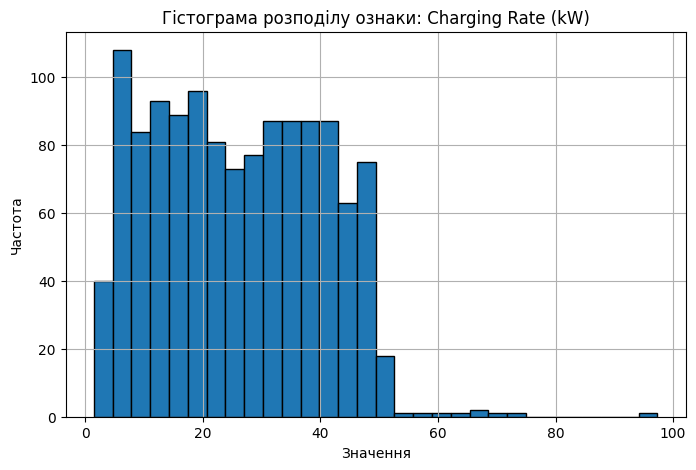

In [7]:
plt.figure(figsize=(8, 5))
df['Charging Rate (kW)'].hist(bins=30, edgecolor='black')
plt.title(f'Гістограма розподілу ознаки: Charging Rate (kW)')
plt.xlabel('Значення')
plt.ylabel('Частота')
plt.show()


In [8]:
charging_rate_column = df['Charging Rate (kW)']

median_value = charging_rate_column.median()

print(f"Медіана стовпця 'Charging Rate (kW)' складає: {median_value}")

Медіана стовпця 'Charging Rate (kW)' складає: 25.603799331857445


In [9]:
new_df['charging_rate_kw'] = df['Charging Rate (kW)'].fillna(median_value)

In [10]:
# Оновлення даних
new_df['energy_consumed_kwh'] = new_df['charging_rate_kw'] * new_df['charging_duration_h']

In [11]:
# Конвертація 'Charging Start Time' у datetime
start_datetime = pd.to_datetime(new_df['charging_start_time'])

# Визначення функції для категоризації часу доби
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:  # Від 22:00 до 5:59
        return 'Night'

# Застосування функції оновлення даних
new_df['time_of_day'] = start_datetime.dt.hour.apply(get_time_of_day)
new_df['day_of_week'] = start_datetime.dt.day_name()

In [12]:
new_df['charging_cost_usd'] = df['Charging Cost (USD)']
new_df['vehicle_age_years'] = df['Vehicle Age (years)']
new_df['charger_type'] = df['Charger Type']
new_df['user_type'] = df['User Type']

In [13]:
new_df['distance_driven_since_last_charge_km'] = df['Distance Driven (since last charge) (km)'].fillna(0)

In [14]:
# Встановлення верхньої межі температури в 50 градусів Цельсія
new_df['temperature_c'] = df['Temperature (°C)'].clip(upper=50)

In [15]:
new_df['state_of_charge_start'] = df['State of Charge (Start %)'].clip(0, 100)
new_df['state_of_charge_end'] = df['State of Charge (End %)'].clip(0, 100)

In [16]:
# Знаходження початкового заряду у КВт-год
start_charge_kwh = (new_df['state_of_charge_start'] / 100) * new_df['battery_capacity_kwh']

# Знаходження кінцевого заряду у КВт-год
calculated_end_charge_kwh = start_charge_kwh + new_df['energy_consumed_kwh']

# Знаходження кінцевого заряду у відсотках
df['State of Charge (End %)'] = np.minimum(
    1,
    calculated_end_charge_kwh / new_df['battery_capacity_kwh']
) * 100

In [17]:
encoded_df = new_df.copy()

In [18]:
encoded_df['day_of_week'].value_counts()

day_of_week
Monday       192
Tuesday      192
Wednesday    192
Thursday     192
Friday       192
Saturday     192
Sunday       168
Name: count, dtype: int64

In [19]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
encoded_day_weeks = pd.Categorical(encoded_df['day_of_week'], categories=days_order, ordered=True).codes
encoded_df['day_of_week'] = encoded_day_weeks

encoded_df['day_of_week'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

In [20]:
encoded_df['time_of_day'].value_counts()

time_of_day
Night        440
Morning      330
Afternoon    330
Evening      220
Name: count, dtype: int64

In [21]:
days_order = ['Morning', 'Afternoon', 'Evening', 'Night']
encoded_time_of_day = pd.Categorical(encoded_df['time_of_day'], categories=days_order, ordered=True).codes
encoded_df['time_of_day'] = encoded_time_of_day

encoded_df['time_of_day'].unique()

array([3, 0, 1, 2], dtype=int8)

In [22]:
encoded_df['vehicle_model'].value_counts()

vehicle_model
Tesla Model 3    280
Hyundai Kona     266
Nissan Leaf      260
BMW i3           258
Chevy Bolt       256
Name: count, dtype: int64

In [23]:
vech_freq_map = encoded_df['vehicle_model'].value_counts(normalize=True)
encoded_df['vehicle_model'] = encoded_df['vehicle_model'].map(vech_freq_map)

In [24]:
encoded_df['charging_station_location'].value_counts()

charging_station_location
Los Angeles      297
San Francisco    264
Houston          262
New York         255
Chicago          242
Name: count, dtype: int64

In [25]:
vech_freq_map = encoded_df['charging_station_location'].value_counts(normalize=True)
encoded_df['charging_station_location'] = encoded_df['charging_station_location'].map(vech_freq_map)

In [26]:
encoded_df = pd.get_dummies(encoded_df, columns=['charger_type', 'user_type'], drop_first=True)

In [27]:
station_mean_cost = encoded_df.groupby('charging_station_id')['charging_cost_usd'].mean()

display(station_mean_cost.nunique())
display(encoded_df['charging_station_id'].nunique())

encoded_df['charging_station_id'] = encoded_df['charging_station_id'].map(station_mean_cost)

462

462

In [28]:
scaled_df = encoded_df.copy()

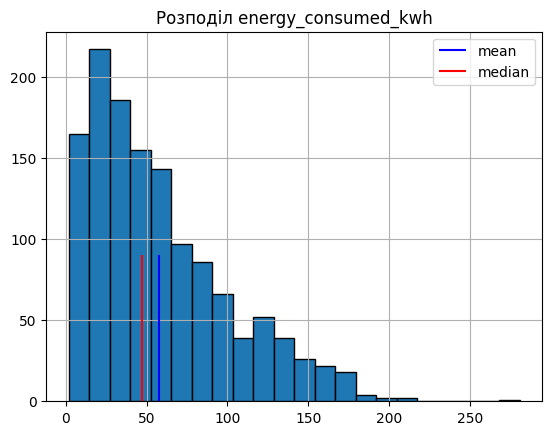

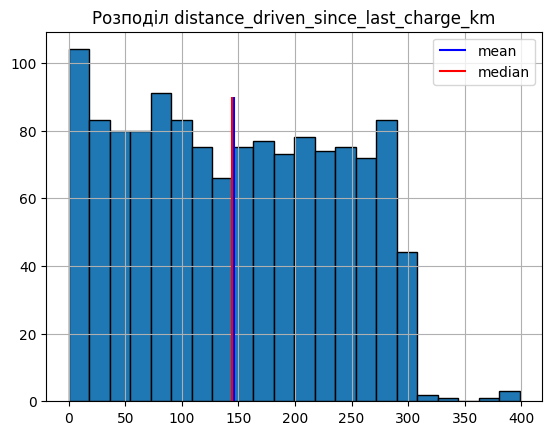

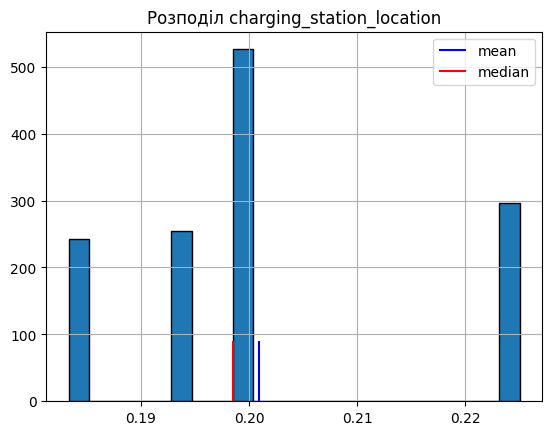

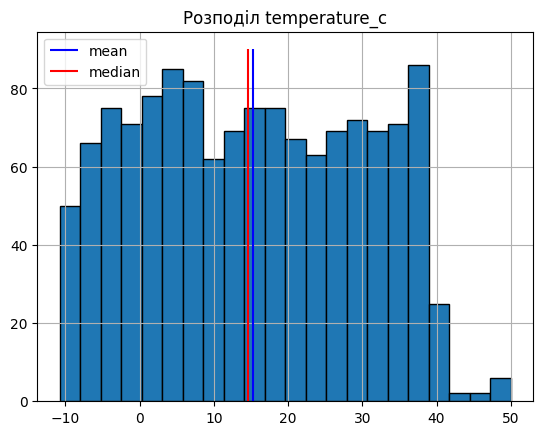

In [29]:
for col in ['energy_consumed_kwh', 'distance_driven_since_last_charge_km', 'charging_station_location', 'temperature_c']:
    scaled_df[col].hist(bins=22, edgecolor='black')
    plt.vlines(scaled_df[col].mean(), colors='b', ymin=0, ymax=90, label='mean')
    plt.vlines(scaled_df[col].median(), colors='r', ymin=0, ymax=90, label='median')
    plt.legend()
    plt.title(f'Розподіл {col}')
    plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

new_scaler = scaler.fit_transform(scaled_df[['charging_station_location']])
pd.DataFrame(new_scaler).describe()
scaled_df['charging_station_location'] = new_scaler

,0
count,1.320000e+03
mean,2.657807e-16
std,1.000379e+00
min,-1.306262e+00
25%,-7.962055e-01
50%,-2.422669e-01
75%,5.594990e-01
max,5.194966e+00


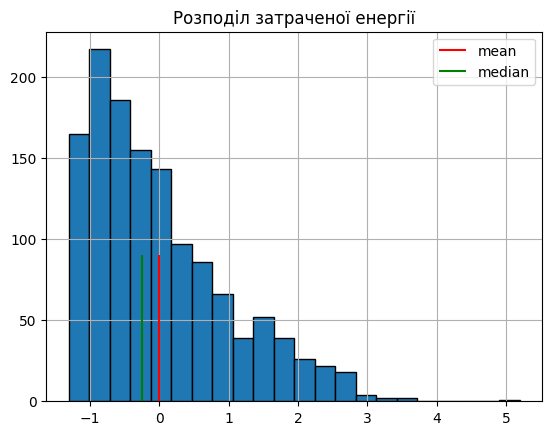

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

new_scaler = scaler.fit_transform(scaled_df[['energy_consumed_kwh']])
new_frame = pd.DataFrame(new_scaler)

display(new_frame.describe())

scaled_df['energy_consumed_kwh'] = new_scaler

new_frame.hist(bins=22, edgecolor='black')
plt.vlines(new_frame.mean(), colors='r', ymin=0, ymax=90, label='mean')
plt.vlines(new_frame.median(), colors='g', ymin=0, ymax=90, label='median')
plt.legend()
plt.title(f'Розподіл затраченої енергії')
plt.show()

In [38]:
connection = sqlite3.connect('data/cleaned-data.db')

scaled_df.to_sql('Main Table', connection, if_exists='replace', index=False)

conn.close()